# Izhikevich neuron

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine

In [3]:
from neuroprobnum.utils import plot_utils as pltu

# Model parameters

In [4]:
solver_method = 'FE'

In [5]:
# Select modes to generate data for.
neuron_modes = [
    'Tonic spiking'              ,
    'Phasic spiking'             ,
    'Tonic bursting'             ,
    'Phasic bursting'            ,
    'Mixed mode'                 ,
    'Spike frequency adaptation' ,
    'Class 1'                    ,
    'Class 2'                    ,
    'Spike latency'              ,
    'Subthreshold oscillations'  ,
    'Resonator'                  ,
    'Integrator'                 ,
    'Rebound spike'              ,
    'Rebound burst'              ,
    'Threshold variability'      ,
    'DAP'                        ,
    'Inhibition-induced spiking' ,
    'Inhibition-induced bursting',
]

# Data

## Generator

In [6]:
from neuroprobnum.models.izhikevich import INmodel, INParameters
from neuroprobnum.generator.generator_in import DataGeneratorIN

gens = {}

for neuron_mode in neuron_modes:
    # Generate neuron instance.
    neuron_parameters, stimulus_parameters, t_parameters = INParameters().select_mode(neuron_mode)
    neuron = INmodel(neuron_parameters, stimulus_parameters)
    tmax = t_parameters['tmax']

    # Generate solver instance.
    gens[neuron_mode] = DataGeneratorIN(
        y0=neuron.y0, t0=0.0, h0=t_parameters['dt'], tmax=tmax,
        gen_det_sols=True, gen_acc_sols=True, return_vars=['ys', 'events'],
        model=neuron, n_samples=100, base_folder='data/examples_in'
    )
    gens[neuron_mode].original_dt = t_parameters['dt']
    gens[neuron_mode].update_subfoldername(neuron=neuron_mode.replace('-', '_').replace(' ', '_'))

In [7]:
data_pert_method = 'abdulle_ln'

## Test

  0%|          | 0/100 samples [00:00<?]

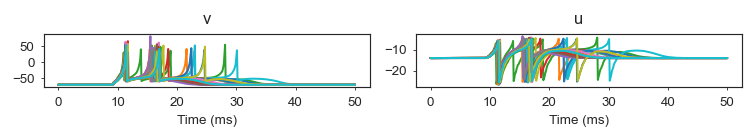

ODE_solutions(n_samples=100)

In [8]:
gens['DAP'].gen_sol(method=solver_method, adaptive=0, plot=True, step_param=gens['DAP'].original_dt, pert_method=data_pert_method)

  0%|          | 0/100 samples [00:00<?]

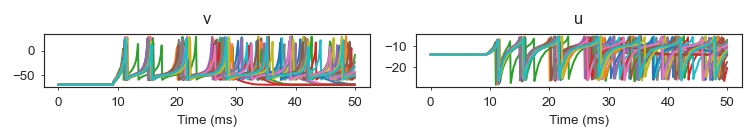

ODE_solutions(n_samples=100)

In [9]:
gens['DAP'].gen_sol(method=solver_method, adaptive=2, plot=True, step_param=gens['DAP'].original_dt, pert_method=data_pert_method)

## Generate data

In [10]:
for neuron_mode, gen in gens.items():
    gen.gen_and_save_data(
        method=solver_method, adaptive=0, pert_method=data_pert_method, step_param=gen.original_dt,
        plot=True, overwrite=False,
    )

  neuron_Tonic_spiking_tmax_100/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
 neuron_Phasic_spiking_tmax_200/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
 neuron_Tonic_bursting_tmax_220/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
 neuron_Phasic_bursting_tmax_200/FE_f(0.2)_abdulle_ln(1).pkl --> Data already exists.
     neuron_Mixed_mode_tmax_160/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
neuron_Spike_frequency_adaptation_tmax_85/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
        neuron_Class_1_tmax_300/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
        neuron_Class_2_tmax_300/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
   neuron_Spike_latency_tmax_100/FE_f(0.2)_abdulle_ln(1).pkl --> Data already exists.
neuron_Subthreshold_oscillations_tmax_200/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
      neuron_Resonator_tmax_400/FE_f(0.25)_abdulle_ln(1).pkl --> Data already exists.
     neuron_Integrator_tmax_100/FE

## Load data

In [11]:
from neuroprobnum.generator.dataloader import DataLoader
import pandas as pd

df = pd.DataFrame()

for neuron_mode, gen in gens.items():
    neuron_mode_df = DataLoader(gen).load_data2dataframe(
        [(data_pert_method, 0, [solver_method], [gen.original_dt])], MAEs=False, allowgenerror=True)
    assert len(neuron_mode_df) == 1
    
    neuron_mode_df['neuron_mode'] = neuron_mode
    neuron_mode_df[['ts_org', 'vs_org', 'events_org', 'stim', 'stim_ts']] = None
    
    ts_org, vs_org, us_org, _, _, events_org = gen.model.original_solve(
        tmax=gen.tmax, dt=gen.original_dt, clip=False)
    
    stim_ts = np.arange(gen.t0, gen.tmax, gen.original_dt/10)
    stim = np.array([gen.model.get_I_at_t(t=t) for t in stim_ts])
    
    neuron_mode_df.at[0, 'ts_org'] = ts_org
    neuron_mode_df.at[0, 'vs_org'] = vs_org
    neuron_mode_df.at[0, 'events_org'] = events_org
    neuron_mode_df.at[0, 'stim'] = stim
    neuron_mode_df.at[0, 'stim_ts'] = stim_ts
    
    df = df.append(neuron_mode_df, ignore_index=True)
    
df.columns.tolist()

['acc_events',
 'acc_ts',
 'acc_vs',
 'adaptive',
 'det_events',
 'det_nODEcalls',
 'det_run_time',
 'det_ts',
 'det_vs',
 'events',
 'method',
 'nODEcalls',
 'n_samples',
 'pert_method',
 'pert_param',
 'run_times',
 'seed',
 'step_param',
 't0',
 'tmax',
 'ts',
 'vs',
 'neuron_mode',
 'ts_org',
 'vs_org',
 'events_org',
 'stim',
 'stim_ts']

### Compute KDEs

In [12]:
from neuroprobnum.utils.metric_utils import compute_kde

df[['kde', 'kde_ts']] = None

for i, row in df.iterrows():
    kde_ts = np.linspace(row.t0, row.tmax, 2001)
    df.at[i, 'kde_ts'] = kde_ts
    
try:
    from joblib import Parallel, delayed
    df['kde'] = Parallel(n_jobs=np.maximum(len(df), 25))(delayed(compute_kde)(np.concatenate([events[0] for events in row.events]), row.kde_ts, np.mean([len(e_list[0]) for e_list in row.events])) for i, row in df.iterrows())
    
except ImportError:
    for i, row in df.iterrows():
        kde = compute_kde(X=np.concatenate([events[0] for events in row.events]), kde_ts=row.kde_ts, scale=np.mean([len(e_list[0]) for e_list in row.events]))
        df.at[i, 'kde'] = kde

# Plot

In [13]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs, plot_events, plot_kde


rows_per_mode = 6

def plot_row(axs, row, nraster=5):
    
    assert axs.size == rows_per_mode, axs.size

    plot_stim(ax=axs[0], ts=row.stim_ts, stim=row.stim)
    plot_vs(ax=axs[1], ts=row.acc_ts, vs=row.acc_vs, c='k')
    plot_vs(ax=axs[2], ts=row.ts_org, vs=row.vs_org, c='C2')
    plot_vs(ax=axs[3], ts=row.det_ts, vs=row.det_vs, c='C1')
    plot_kde(ax=axs[4], kde_ts=row.kde_ts, kde=row.kde)
    plot_events(ax=axs[5], events=row.events[:nraster] if nraster > 0 else None, event_idx=0, event_traces={
        'det.': (row.det_events[0], 'C1'), 'org.': (row.events_org, 'C2'), 'ref.': (row.acc_events[0], 'k')}, lw=0.8)
    
    pltu.make_share_xlims(axs)
    
    for ax in axs[:-1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

        
def plot_modes(num_rows, num_cols, neuron_mode_plot_order, xsize='fullwidth', panel_nums='auto', ysize='auto', nraster=5, height_last_row=0.75, ysizerow=0.34, yoffsize=0.3):
    fig, axs = pltu.subplots(num_cols, rows_per_mode*num_rows, ysizerow=ysizerow, yoffsize=yoffsize, ysize=ysize, xsize=xsize, squeeze=False, gridspec_kw=dict(
        height_ratios=([0.07] + [0.21]*int(rows_per_mode-2) + [height_last_row])*num_rows))

    despine()

    for i, neuron_mode in enumerate(neuron_mode_plot_order):
        if i*rows_per_mode >= axs.size:
            break
        axs_set = axs[int(i/num_cols)*rows_per_mode:(int(i/num_cols)+1)*rows_per_mode, i%num_cols]

        row = df[df.neuron_mode == neuron_mode]
        assert len(row) == 1
        row = row.iloc[0]
        plot_row(axs=axs_set, row=row, nraster=nraster)

        axs_set[0].set_title(neuron_mode, loc='center', ha='center', fontsize=plt.rcParams['font.size'], va='top', y=2.8)
        
    for ax in axs[:, 1:].flat:
        ax.set_ylabel(None)

    pltu.set_labs(axs[np.arange(0, num_rows)*rows_per_mode, :], panel_nums=panel_nums, panel_num_space=4, panel_num_va='top', panel_num_y=2.8)
    fig.align_labels()

    # Adjust spacing
    mode_spacing = 0.07
    plt.tight_layout(h_pad=-3.7 if num_rows > 1 else -0.1, rect=[0, (num_rows-1)*mode_spacing, 1, 1])
    for i in range(num_rows):
        pltu.move_box(axs[i*rows_per_mode:(i+1)*rows_per_mode], dy=-mode_spacing*i)
        for j in np.arange(1, rows_per_mode):
            if j != 4:
                pltu.make_share_ylims(axs[i*rows_per_mode+j, :])
            
    return fig, axs

## Two modes

### Plot

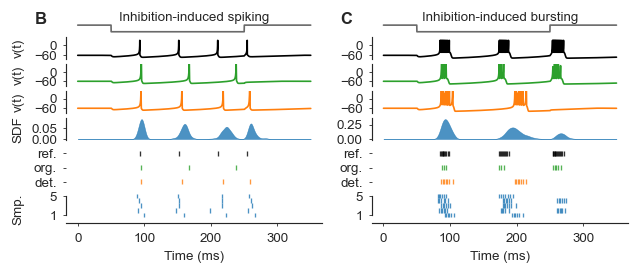

In [14]:
neuron_mode_plot_order = [
    'Inhibition-induced spiking' ,
    'Inhibition-induced bursting',
]
    
fig, axs = plot_modes(num_rows=1, num_cols=len(neuron_mode_plot_order), neuron_mode_plot_order=neuron_mode_plot_order,
                      panel_nums=['B', 'C', 'D', 'E'], xsize=pltu.FULLPAGE_WIDTH * 0.85)

pltu.savefig("fig2b_c")
plt.show()

### Text

In [15]:
neuron_mode = 'Inhibition-induced spiking'
print(neuron_mode)

row = df[df.neuron_mode == neuron_mode]
assert len(row) == 1
row = row.iloc[0]

det_spikes = np.array(row.det_events[0])
acc_spikes = np.array(row.acc_events[0])

for i in range(4):
    print(f"Error of det. spike {i+1} = {det_spikes[i] - acc_spikes[i]:.1f}")

prb_spikes = np.squeeze(np.array([e_list[0][:3] for e_list in row.events], dtype=float))
for i in range(prb_spikes.shape[1]):
    assert prb_spikes[:, i].size == gen.n_samples
    print(f"Std of spike {i+1} = {np.std(prb_spikes[:, i], ddof=1):.1f}")
    
row.step_param

Inhibition-induced spiking
Error of det. spike 1 = 1.8
Error of det. spike 2 = 4.7
Error of det. spike 3 = 8.2
Error of det. spike 4 = 3.9
Std of spike 1 = 3.0
Std of spike 2 = 5.6
Std of spike 3 = 7.1


0.5

In [16]:
neuron_mode = 'Inhibition-induced bursting'
print(neuron_mode)

row = df[df.neuron_mode == neuron_mode]
assert len(row) == 1
row = row.iloc[0]

org_spikes = np.array(row.events_org)
det_spikes = np.array(row.det_events[0])
acc_spikes = np.array(row.acc_events[0])


print('n_spikes_org:', org_spikes.size)
print('n_spikes_det:', det_spikes.size)
print('n_spikes_acc:', acc_spikes.size)
print('mean n_spikes_prob:', f"{np.mean([len(e_list[0]) for e_list in row.events]):.1f}")
print('SD n_spikes_prob:', f"{np.std([len(e_list[0]) for e_list in row.events], ddof=1):.1f}")

row.step_param

Inhibition-induced bursting
n_spikes_org: 11
n_spikes_det: 14
n_spikes_acc: 33
mean n_spikes_prob: 13.8
SD n_spikes_prob: 2.5


0.5

In [17]:
row.step_param

0.5

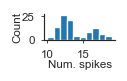

In [18]:
assert row.neuron_mode == 'Inhibition-induced bursting'

n_spikes = [len(e_list[0]) for e_list in row.events]
n_burst = [np.sum(np.diff(e_list[0]) > 10) + 1 for e_list in row.events]

fig, ax = plt.subplots(1, 1, figsize=(1.1, 0.7))
despine()

ax.hist(n_spikes)
ax.set_xlabel('Num. spikes', labelpad=0.1, fontsize=7)
ax.set_ylabel('Count', labelpad=0.1, fontsize=7)
ax.tick_params(axis='both', which='major', labelsize=7)
plt.tight_layout()
pltu.savefig("fig2c_inlet", facecolor='none', bbox_inches='tight')
plt.show()

In [19]:
unburst, counts = np.unique(n_burst, return_counts=True)
print(unburst, counts)
counts[1] / (counts[0] + counts[1])

[2 3] [67 33]


0.33

## All modes

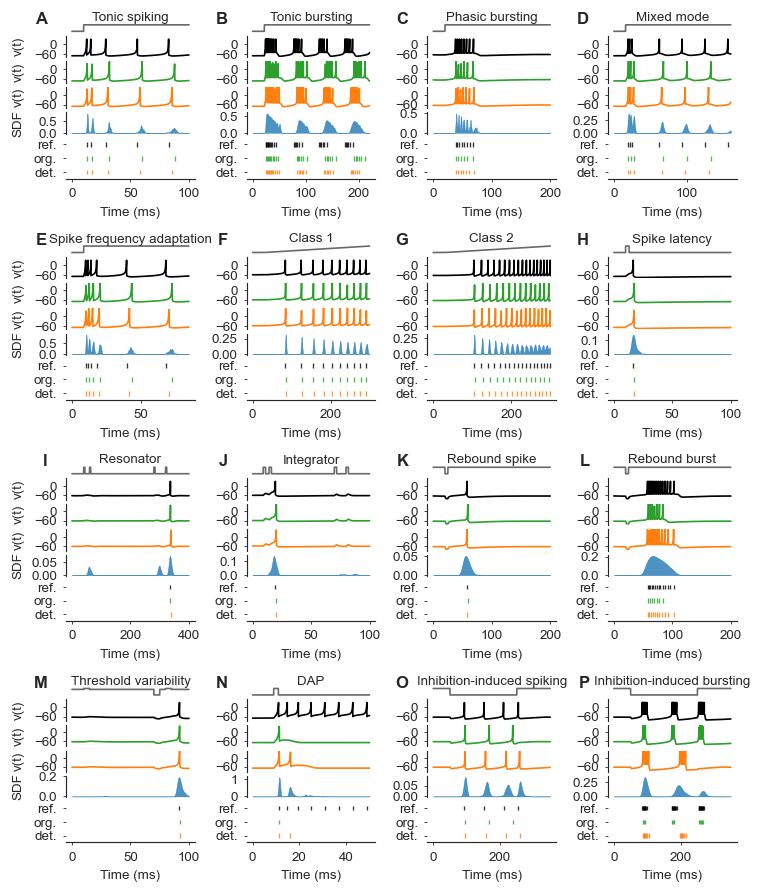

In [26]:
neuron_mode_plot_order = [
    'Tonic spiking'              ,
    'Tonic bursting'             ,
    'Phasic bursting'            ,
    'Mixed mode'                 ,
    'Spike frequency adaptation' ,
    'Class 1'                    ,
    'Class 2'                    ,
    'Spike latency'              ,
    'Resonator'                  ,
    'Integrator'                 ,
    'Rebound spike'              ,
    'Rebound burst'              ,
    'Threshold variability'      ,
    'DAP'                        ,
    'Inhibition-induced spiking' ,
    'Inhibition-induced bursting',
]
   
fig, axs = plot_modes(num_rows=4, num_cols=4, neuron_mode_plot_order=neuron_mode_plot_order, xsize='fullwidth', nraster=0, height_last_row=0.4, ysizerow=0.3)

pltu.savefig("FigS1")
plt.show()

## DAP

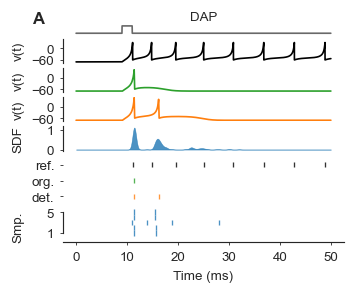

In [27]:
neuron_mode_plot_order = ['DAP']
    
fig, axs = plot_modes(num_rows=1, num_cols=1, neuron_mode_plot_order=neuron_mode_plot_order,
                      xsize='col', ysize=2.5)

pltu.savefig("fig8_a")
plt.show()

In [22]:
neuron_mode = 'DAP'
print(neuron_mode)

row = df[df.neuron_mode == neuron_mode]
assert len(row) == 1
row = row.iloc[0]

org_spikes = np.array(row.events_org)
det_spikes = np.array(row.det_events[0])
acc_spikes = np.array(row.acc_events[0])


print('n_spikes_det:', org_spikes.size)
print('n_spikes_det:', det_spikes.size)
print('n_spikes_acc:', acc_spikes.size)
print(f'mean n_spikes_prob: {np.mean([len(e_list[0]) for e_list in row.events]):.1f}')
print(f"SD n_spikes_prob: {np.std([len(e_list[0]) for e_list in row.events], ddof=1):.1f}")

DAP
n_spikes_det: 1
n_spikes_det: 2
n_spikes_acc: 8
mean n_spikes_prob: 2.3
SD n_spikes_prob: 0.6
